# Simulating an RC circuit in NEURON

In this simple demo, we will test out your Jupyter environment by simulating the RC circuit presented in lecture today with NEURON.  
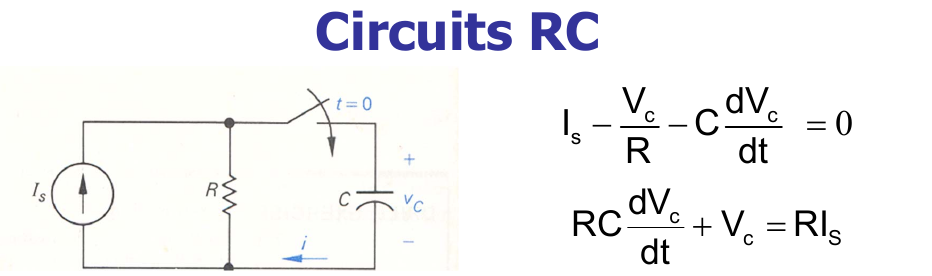

## Step 1: Setup

In [1]:
# Setup inline plotting
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# For Google Colab, this line installs NEURON
!pip install neuron quantities

In [3]:
# We will let this library handle unit conversion for us
import quantities as pq
from quantities import um, nS, mV, cm, ms, nA, S, uF

In [4]:
# Import and initialize NEURON
import neuron
from neuron import h
h.load_file("stdrun.hoc")

1.0

In [5]:
# Import other modules we need
import numpy as np

## Step 2: Define the circuit
We will use a single compartment, called a "Section" (more on that in next lectures). <br>
It has a cylindrical geometry with length "L" and a diameter "diam", and a specific capacitance "cm" (capacitance per area) <br>
**Unit conversion is a common source of error, so we will be explicit with our units.** 

In [6]:
soma = h.Section()

### Query NEURON for the expected units for soma.L & soma.diam

In [7]:
[h.units(x) for x in ["L", "diam"]]

['um', 'um']

In [8]:
soma.L = 10 * um
soma.diam =  10 * um

In [9]:
volume = soma(0.5).volume() * um**3

In [10]:
area = soma(0.5).area() * um**2

### Assign the membrane capacitance "everywhere"

In [11]:
h.units("cm")  # Query the expected units

'uF/cm2'

In [12]:
for sec in soma.wholetree():
    sec.cm = 1 * uF/cm**2 #  specific membrane capacitance (micro Farads / cm^2)

### Add (insert) a leak conductance G = 1/R

In [13]:
soma.insert("pas")

__nrnsec_0x37886f0

In [14]:
h.units("g_pas")

'S/cm2'

In [15]:
G = 5 * nS  # R = 1/G in our RC circuit

In [16]:
# Assign the leak conductance everywhere
for seg in soma:
    seg.pas.g = (G/area).rescale(S/cm**2)  # Compute specific conductance, and rescale to units of 'S/cm2'

### Add a current injection

In [17]:
stim = h.IClamp(soma(0.5))

In [18]:
stim.delay = 500 * ms  # Inject current 500ms after the start of the simulation 
stim.dur = 20 * ms  # stop injecting current at 520ms 
stim.amp = 0.1 * nA  # Inject 0.1 nA of current

## Step 3: Run the simulation

### Define recordings of simulation variables

In [19]:
soma_v = h.Vector().record(soma(0.5)._ref_v)
t = h.Vector().record(h._ref_t)

### Set the initial voltage

In [20]:
h.finitialize( float(-70*mV) )

1.0

### Run the simulation for 1500ms

In [21]:
h.continuerun( float(1500 * ms) )

0.0

## Step 4: Plot the results

(array([-75., -70., -65., -60., -55., -50., -45., -40., -35.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

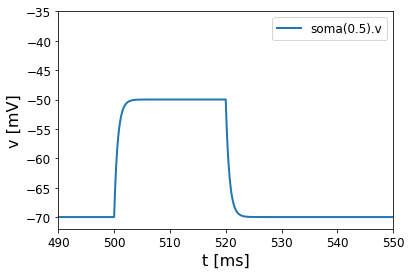

In [22]:
plt.plot(t, soma_v, lw=2, label="soma(0.5).v")
plt.axis([490,550,-72, -35])
plt.legend(fontsize=12)
plt.xlabel("t [ms]", size=16)
plt.ylabel("v [mV]", size=16)
plt.xticks(size=12)
plt.yticks(size=12)

### Compute the theoretical result for comparison

The predicted equilibrium value of the voltage for $t \rightarrow \infty$:

In [23]:
v_infinity = soma(0.5).pas.e * mV + stim.amp * nA / G

In [24]:
v_infinity

array(-50.) * mV

The predicted time constant:

In [25]:
tau = soma(0.5).cm * uF/cm**2 / (soma(0.5).pas.g * S/cm**2)

In [26]:
tau = tau.rescale(ms)  # Convert to milliseconds

In [27]:
v_rest = soma(0.5).pas.e * mV

Predict the voltage dynamics at onset of the stimulation current:

In [28]:
t_theory = np.arange(500,520, 0.1) * ms
v_theory = v_rest + (v_infinity-v_rest)*(1-np.exp(-(t_theory-500*ms)/tau))

(array([-75., -70., -65., -60., -55., -50., -45., -40., -35.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

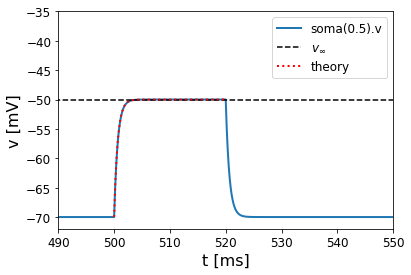

In [29]:
plt.plot(t, soma_v, lw=2, label="soma(0.5).v")
plt.plot([t[0],t[-1]], [v_infinity, v_infinity], 'k--', label="$v_\infty$")
plt.plot(t_theory, v_theory, 'r:', lw=2, label="theory")
plt.axis([490,550,-72, -35])
plt.legend(fontsize=12)
plt.xlabel("t [ms]", size=16)
plt.ylabel("v [mV]", size=16)
plt.xticks(size=12)
plt.yticks(size=12)

### There is excellent agreement between the theoretical predictions and the numerical simulations of the RC circuit with NEURON!